In [42]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt

In [24]:
data=pd.read_csv("D:/STATISTIKA/PERSIAPAN MENUJU MAGISTER/digitaltalent/Materi AI DTS 2019/PROJECT 2/store_item_demand_forecasting/demand_forecasting_item1.csv",sep=";")

In [5]:
data.head()

,date,store,item,sales
0,01/01/2013,1,1,13
1,02/01/2013,1,1,11
2,03/01/2013,1,1,14
3,04/01/2013,1,1,13
4,05/01/2013,1,1,10


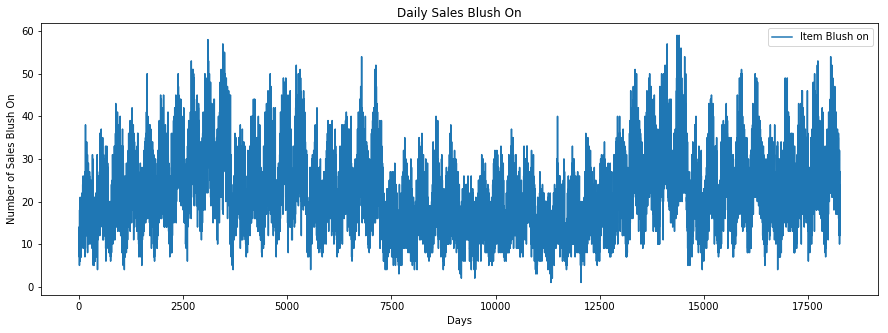

In [8]:
# Create a time series plot.
plt.figure(figsize = (15, 5))
plt.plot(data["sales"], label = "Item Blush on")
plt.xlabel("Days")
plt.ylabel("Number of Sales Blush On")
plt.title("Daily Sales Blush On")
plt.legend()
plt.show()

In [9]:
# Let's load the required libs.
# We'll be using the Tensorflow backend (default).
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle

Using TensorFlow backend.


In [33]:
# Get the raw data values from the pandas data frame.

data_raw = pd.DataFrame(data1).values.astype("float64")

# We apply the MinMax scaler from sklearn
# to normalize data in the (0, 1) interval.
scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(data_raw)

# Print a few values.
dataset[0:5]

array([[0.20689655],
       [0.17241379],
       [0.22413793],
       [0.20689655],
       [0.15517241]])

In [34]:
# Using 60% of data for training, 40% for validation.
TRAIN_SIZE = 0.60

train_size = int(len(dataset) * TRAIN_SIZE)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print("Number of entries (training set, test set): " + str((len(train), len(test))))

Number of entries (training set, test set): (10956, 7304)


In [35]:
# FIXME: This helper function should be rewritten using numpy's shift function. See below.
def create_dataset(dataset, window_size = 1):
    data_X, data_Y = [], []
    for i in range(len(dataset) - window_size - 1):
        a = dataset[i:(i + window_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + window_size, 0])
    return(np.array(data_X), np.array(data_Y))

In [36]:
# Create test and training sets for one-step-ahead regression.
window_size = 1
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)
print("Original training data shape:")
print(train_X.shape)

# Reshape the input data into appropriate form for Keras.
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
print("New training data shape:")
print(train_X.shape)

Original training data shape:
(10954, 1)
New training data shape:
(10954, 1, 1)


Build simple LSTM model on training data
The LSTM architecture here consists of:

One input layer.
One LSTM layer of 4 blocks.
One Dense layer to produce a single output.
Use MSE as loss function.
Many different architectures could be considered. But this is just a quick test, so we'll keep things nice and simple.

In [37]:
def fit_model(train_X, train_Y, window_size = 1):
    model = Sequential()
    
    model.add(LSTM(4, 
                   input_shape = (1, window_size)))
    model.add(Dense(1))
    model.compile(loss = "mean_squared_error", 
                  optimizer = "adam")
    model.fit(train_X, 
              train_Y, 
              epochs = 100, 
              batch_size = 1, 
              verbose = 2)
    
    return(model)

# Fit the first model.
model1 = fit_model(train_X, train_Y, window_size)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
 - 45s - loss: 0.0144
Epoch 2/100
 - 32s - loss: 0.0132
Epoch 3/100
 - 33s - loss: 0.0132
Epoch 4/100
 - 33s - loss: 0.0132
Epoch 5/100
 - 36s - loss: 0.0132
Epoch 6/100
 - 31s - loss: 0.0132
Epoch 7/100
 - 34s - loss: 0.0132
Epoch 8/100
 - 31s - loss: 0.0132
Epoch 9/100
 - 34s - loss: 0.0132
Epoch 10/100
 - 37s - loss: 0.0132
Epoch 11/100
 - 35s - loss: 0.0132
Epoch 12/100
 - 33s - loss: 0.0132
Epoch 13/100
 - 35s - loss: 0.0132
Epoch 14/100
 - 36s - loss: 0.0132
Epoch 15/100
 - 33s - loss: 0.0132
Epoch 16/100
 - 31s - loss: 0.0132
Epoch 17/100
 - 30s - loss: 0.0132
Epoch 18/100
 - 30s - loss: 0.0132
Epoch 19/100
 - 30s - loss: 0.0132
Epoch 20/100
 - 30s - loss: 0.0132
Epoch 21/100
 - 30s - loss: 0.0132
Epoch 22/100
 - 31s - loss: 0.0132
Epoch 23/100
 - 30s - loss: 0.0132
Epoch 24/100
 - 31s - loss: 0.0132
Epoch 25/100
 - 30s - loss: 0.0132
Epoch 26/100
 

In [50]:
def predict_and_score(model, X, Y):
    # Make predictions on the original scale of the data.
    pred = scaler.inverse_transform(model.predict(X))
    # Prepare Y data to also be on the original scale for interpretability.
    orig_data = scaler.inverse_transform([Y])
    # Calculate RMSE.
    score = math.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
    return(score, pred)

rmse_train, train_predict = predict_and_score(model1, train_X, train_Y)
rmse_test, test_predict = predict_and_score(model1, test_X, test_Y)

print("Training data score: %.2f RMSE" % rmse_train)
print("Test data score: %.2f RMSE" % rmse_test)

Training data score: 6.63 RMSE
Test data score: 7.07 RMSE


In [51]:
test_predict

array([[12.866058],
       [11.913135],
       [13.277126],
       ...,
       [19.694353],
       [15.335226],
       [22.17514 ]], dtype=float32)

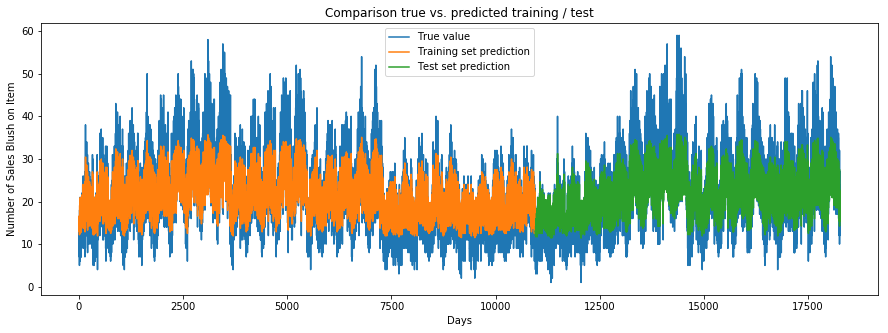

In [44]:
# Start with training predictions.
train_predict_plot = np.empty_like(dataset)
train_predict_plot[:, :] = np.nan
train_predict_plot[window_size:len(train_predict) + window_size, :] = train_predict

# Add test predictions.
test_predict_plot = np.empty_like(dataset)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (window_size * 2) + 1:len(dataset) - 1, :] = test_predict

# Create the plot.
plt.figure(figsize = (15, 5))
plt.plot(scaler.inverse_transform(dataset), label = "True value")
plt.plot(train_predict_plot, label = "Training set prediction")
plt.plot(test_predict_plot, label = "Test set prediction")
plt.xlabel("Days")
plt.ylabel("Number of Sales Blush on Item")
plt.title("Comparison true vs. predicted training / test")
plt.legend()
plt.show()

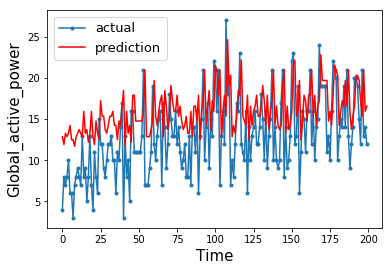

In [88]:
aa=[x for x in range(200)]
plt.plot(aa, ytest[:200], marker='.', label="actual")
plt.plot(aa, test_predict[:200], 'r', label="prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time', size=15)
plt.legend(fontsize=13)
plt.show()

In [83]:
pred=pd.DataFrame(test_predict)
pred

,0
0,12.866058
1,11.913135
2,13.277126
3,12.866058
4,13.277126
5,14.228227
6,12.500663
7,12.500663
8,11.693316
9,12.866058


In [87]:
ytest=pd.DataFrame(scaler.inverse_transform([test_Y])).T
ytest

,0
0,4.0
1,8.0
2,7.0
3,8.0
4,10.0
5,6.0
6,6.0
7,3.0
8,7.0
9,8.0
